# **Extracting Early Print Lab Corpus Metadata**

This notebook will generate a csv file with the corpus metadata. More about the [Early Print Lab](https://earlyprint.org/lab/) can be found linked, and their notebooks can are [linked here](https://earlyprint.org/jupyterbook/metadata.html). Some of the source code in this notebook originates from the Early Print Lab (these blocks will be noted with their logo embedded into the text explaining the code above.

The metadata extracted in this tutorial can be found in their [GitHub repository](https://github.com/earlyprint/epmetadata/tree/master/header).

## **1. Environment Set Up**

The libraries imported for extracting the EPL Corpus Metadata are:


*   *Drive*: Used to import the downloaded data
*   *lxml*: Used to extract the metadata from the XML files
*   *Pandas*: Used to structure the metadata and export to a CSV
*   *Regex*: Used to parse and clean the author names
*   *JSON*: Imports the name abbreviation sheet from EPL



In [ ]:
''' DATA IMPORT '''
from google.colab import drive
drive.mount('/content/drive')

import json

Mounted at /content/drive


In [ ]:
''' DATA QUERYING '''
from lxml import etree
parser = etree.XMLParser(collect_ids=False,encoding='utf-8')
nsamp = {'tei': 'http://www.tei-c.org/ns/1.0'} ### EPL Source

''' DATA MANAGEMENT '''
import pandas as pd
import regex as re

### **1.1 Data Import and Structuring**

Multiple data files are imported in this section, the first is a metadata file from EPL. This provides a TCP ID, Author, Title, imprint, language, and keywords. This will be merged with the cleaned metadata to generte a CSV that is cleaner and easier to manipulate.

The next file is the name abbreviation json from the [EPL Repository](https://github.com/earlyprint/jupyterbook/blob/master/name_abbrev.json). This is used to clean the names so they can be accurately parsed.

The third cell will extract the cleaned metadata from the header files in the above [EPL Header GitHub repository](https://github.com/earlyprint/epmetadata/tree/master/header). It will return a dictionary and dataframe with the author, date, publisher, and publication location. The dataframe was created on a local machine using the below code, so the files did not have to be uploaded to multiple different locations. Assembling the metadata takes about ten minutes to parse through the 60,000 texts.

In [ ]:
''' EPL GENERATED METADATA '''
epl = pd.read_csv("/content/drive/My Drive/dhum project (BERT materials)/EPL Corpus/EPL_generated_metadata.csv")

In [ ]:
''' PREPROCESSING THE EPL METADATA:
The EPL Metadata Will be merged with the cleaned metadata. Any EPL source will be indicated as so in the colum  names. TCP ID renames the same as that is the merge colummn for later '''

epl_metadata = epl.drop(columns=['Date','ESTC','STC/Wing'],inplace=False)

In [ ]:
epl_metadata.rename(columns={"Author": "EPL author","Title":"EPL title","Imprint":"EPL imprint","Lang.":"EPL language","Keywords":"EPL Keywords"},inplace=True)

In [ ]:
epl_metadata.head()

,TCP ID,EPL author,EPL title,EPL imprint,EPL language,EPL Keywords
0,A00001,"A., fl. 1593.",[The passoinate [sic] morrice],"Imprinted by R. Bourne? for Richard Jones,",eng,Marriage -- Early works to 1800.
1,A00002,"Aylett, Robert, 1583-1655?","The brides ornaments viz. fiue meditations, mo...","Printed by William Stansby,",eng,NaN
2,A00003,"Ailesbury, Thomas, fl. 1622-1659.",A sermon preached at Paules-Crosse the second ...,Printed by George Eld for Leonard Becket and R...,eng,"Sermons, English -- 17th century."
3,A00005,"Higden, Ranulf, d. 1364. Polycronicon. English...",Here begynneth a shorte and abreue table on th...,In powlys chyrche yarde at the west dore of po...,eng,Great Britain -- History -- To 1485 -- Early w...
4,A00007,"Higden, Ranulf, d. 1364. Polycronicon.",The Cronycles of Englonde with the dedes of po...,In Fletestrete at the sygne of the Sonne by Wy...,eng,Great Britain -- History -- To 1485 -- Early w...


In [ ]:
print (len(epl_metadata))

60327


The first block in this section is from the Early Print Lab [Working with Metadata, Creating Text Networks](https://earlyprint.org/jupyterbook/metadata.html) notebook. The second cell is the adapted version for extracting data from Google Drive.

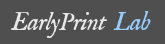

In [ ]:
'''EARLY PRINT LAB CODE | NO NEED TO RUN -----------------------------------------------'''

# Get the full list of metadata files
# (You'll change this line based on where the files are on your computer)
files = glob.glob("../../epmetadata/header/*.xml")

all_data = [] # Empty list for data
index = [] # Empty list for TCP IDs
for f in files: # Loop through each file
    tcp_id = f.split("/")[-1].split("_")[0] # Get TCP ID from filename
    metadata = etree.parse(f, parser) # Create lxml tree for metadata
    title = metadata.find(".//tei:sourceDesc//tei:title", namespaces=nsmap).text # Get title

    # Get author (if there is one)
    try:
        author = metadata.find(".//tei:sourceDesc//tei:author", namespaces=nsmap).text
    except AttributeError:
        author = None

    # Get date (if there is one that isn't a range)
    try:
        date = metadata.find(".//tei:sourceDesc//tei:date", namespaces=nsmap).get("when")
    except AttributeError:
        date = None

    # Add dictionary of data to data list
    all_data.append({'title':title,'author':author,'date':date})

    # Add TCP ID to index list
    index.append(tcp_id)


# Create DataFrame with data and indices
df = pd.DataFrame(all_data, index=index)
df

In [ ]:
''' PARSING METDATA FROM XML HEADERS:
    This block of code has adapted the above data to then extract the metadata from the XML. This was run on a local machine for quicker speed - so just import the final CSV
    in the below cell instead!
'''
metadata_data = [] # Empty list for data
tcps = [] # Empty list for TCP IDs

## extracting the metadata from each file
for file_name in tqdm(files,desc="📖🔍 🪄 finding data...",unit=' text',):
 ## Using the file name to extract the TCP
    match = re.findall(r'(?<=header\\).+(?=_)',file_name)
    tcp_id = match[0]
    ## Using the XML parser to create an xml object that holds all of the metadata
    metadata = etree.parse(file_name,parser)
    title = metadata.find(".//tei:sourceDesc//tei:title", namespaces=nsamp).text

    ## Author
    try:
        author = metadata.find(".//tei:person[@role='creator']/tei:persName", namespaces=nsamp).text
    except AttributeError:
        author = None

    ## Author Gender
    try:
        gender = metadata.find(".//tei:sourceDesc//tei:author", namespaces=nsamp).get("gender")
    except AttributeError:
        gender = None

    ## Author Birth
    try:
        birth = metadata.find(".//tei:person[@role='creator']/tei:birth", namespaces=nsamp).text
    except AttributeError:
        birth = None

    ## Author Death
    try:
        death = metadata.find(".//tei:person[@role='creator']/tei:death", namespaces=nsamp).text
    except AttributeError:
        death = None

    # Get date (if there is one that isn't a range)
    try:
        date = metadata.find(".//tei:sourceDesc//tei:date", namespaces=nsamp).get("when")
    except AttributeError:
        date = None

    # Get publisher (if there is one that isn't a range)
    try:
        publisher = metadata.find(".//tei:person[@type='printer']/tei:persName", namespaces=nsamp).text
    except AttributeError:
        publisher = None
    # Get publisher (if there is one that isn't a range)
    try:
        pub_location = metadata.find(".//tei:sourceDesc//tei:pubPlace", namespaces=nsamp).text
    except AttributeError:
        pub_location = None
      ## Storing the metadata in a dictionary
    current_metadata = {'TCP ID':tcp_id,'title':title,'author':author,'gender':gender,"auth birth":birth,"auth death":death,'pub date':date,'publisher':publisher,'location':pub_location}
    metadata_data.append(current_metadata)
      ## Adding the tcp to the index list
    tcps.append(tcp_id)


print ("✨ data has been found")


''' Generating A Data Frame With the Metadata '''

metadata = pd.DataFrame(metadata_data,index=tcps)
metadata.head()

NameError: name 'tqdm' is not defined

In [ ]:
''' RUN THIS CELL:
    Importing the supplemented metadata
 '''
supplementary = pd.read_csv("/content/drive/My Drive/dhum project (BERT materials)/EPL Corpus/supplementary_metadata.csv")
supplementary.drop(columns=["Unnamed: 0"],inplace=True)
supplementary.head()

,TCP ID,title,author,gender,auth birth,auth death,pub date,publisher,location
0,A00001,[The passoinate [sic] morrice],"A.,",L,NaN,NaN,1593.0,R. Bourne?,[London :
1,A00002,"The brides ornaments viz. fiue meditations, mo...","Aylett, Robert,",M,1583,1655?.,1625.0,William Stansby,London :
2,A00003,A sermon preached at Paules-Crosse the second ...,"Ailesbury, Thomas,",M,NaN,NaN,1623.0,George Eld,London :
3,A00005,Here begynneth a shorte and abreue table on th...,NaN,NaN,NaN,NaN,1515.0,me Iulyan Notary,[Enprynted at Londo[n] :
4,A00007,The Cronycles of Englonde with the dedes of po...,NaN,NaN,NaN,NaN,1528.0,NaN,[Imprynted at London :


# **2. Supplementing EPL Metadata With Extracted Metadata**

The supplementary CSV file that was generated from the XML data provided by EPL will now be added to the dataframe. Preprocessing will also happen so the final dataframe is cleaned and available.

In [ ]:
''' FIRST: Check that the dimensions are similar'''

print ("Length of the EPL Metadata:",len(epl_metadata))
print ("Length of the supplementary Metadata:",len(supplementary))

Length of the EPL Metadata: 60327
Length of the supplementary Metadata: 60331


In [ ]:
''' Identifying the IDs present in the supplementary and not EPL '''
epl_tcps = epl_metadata['TCP ID'].to_list()
sup_tcps = supplementary['TCP ID'].to_list()

missing_ids = []
for id in sup_tcps:
  if id not in epl_tcps:
    print (id)
    missing_ids.append(id)

A49004
A49690
A70386
B15672


In [ ]:
''' MERGING THE DATAFRAMES '''

full_metadata = pd.merge(left=supplementary,right=epl_metadata,on='TCP ID')
full_metadata.head()

,TCP ID,title,author,gender,auth birth,auth death,pub date,publisher,location,EPL author,EPL title,EPL imprint,EPL language,EPL Keywords
0,A00001,[The passoinate [sic] morrice],"A.,",L,NaN,NaN,1593.0,R. Bourne?,[London :,"A., fl. 1593.",[The passoinate [sic] morrice],"Imprinted by R. Bourne? for Richard Jones,",eng,Marriage -- Early works to 1800.
1,A00002,"The brides ornaments viz. fiue meditations, mo...","Aylett, Robert,",M,1583,1655?.,1625.0,William Stansby,London :,"Aylett, Robert, 1583-1655?","The brides ornaments viz. fiue meditations, mo...","Printed by William Stansby,",eng,NaN
2,A00003,A sermon preached at Paules-Crosse the second ...,"Ailesbury, Thomas,",M,NaN,NaN,1623.0,George Eld,London :,"Ailesbury, Thomas, fl. 1622-1659.",A sermon preached at Paules-Crosse the second ...,Printed by George Eld for Leonard Becket and R...,eng,"Sermons, English -- 17th century."
3,A00005,Here begynneth a shorte and abreue table on th...,NaN,NaN,NaN,NaN,1515.0,me Iulyan Notary,[Enprynted at Londo[n] :,"Higden, Ranulf, d. 1364. Polycronicon. English...",Here begynneth a shorte and abreue table on th...,In powlys chyrche yarde at the west dore of po...,eng,Great Britain -- History -- To 1485 -- Early w...
4,A00007,The Cronycles of Englonde with the dedes of po...,NaN,NaN,NaN,NaN,1528.0,NaN,[Imprynted at London :,"Higden, Ranulf, d. 1364. Polycronicon.",The Cronycles of Englonde with the dedes of po...,In Fletestrete at the sygne of the Sonne by Wy...,eng,Great Britain -- History -- To 1485 -- Early w...


### **2.1 Pre-Processing Author Names**

The provided author name list is from the Early Print Lab and can be downloaded at this [GitHub repository](https://github.com/earlyprint/jupyterbook/blob/master/name_abbrev.json). The function used to standardized the author names is from the Early English Print Lab in the Working With MetaData Jupyter notebook (linked above).

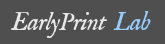

In [ ]:
# NOTE: this function was modified to include a try and except into the function so if the standardize doesn't work it will just return the name
# Get a list of standard early modern first name abbreviations, and what they stand for
with open("/content/drive/My Drive/dhum project (BERT materials)/EPL Corpus/name_abbrev.json", "r") as abbrevfile:
    name_abbrev = json.loads(abbrevfile.read())

def standardize_name(name): # Define our function
    try:
      name = name.replace("[","").replace("]","") # Remove bracket characters
      name = name.strip(",'") # Remove commas and apostrophes from the beginning or end of the name
      name = name.replace("Iohn", "John") # Replace Iohn with John (a common spelling variant)
      # Finally, look through each abbreviation and, if found,
      # replace it with the full first name.
      for k,v in name_abbrev.items():
          name = re.sub(f"{k}[^a-zA-Z\s]", f"{v}", name)
      return name
    except:
      return name

In [ ]:
''' Applying the function to our supplemented data:
    Now using the EPL standardize name function, we will apply it to both the supplemental and the EPL author names in the metadata dataframe using a lambda function
 '''

full_metadata['SD. author'] = full_metadata['author'].apply(standardize_name)


In [ ]:
full_metadata['EPL SD. author'] = full_metadata['EPL author'].apply(standardize_name)

In [ ]:
full_metadata.head()

,TCP ID,title,author,gender,auth birth,auth death,pub date,publisher,location,EPL author,EPL title,EPL imprint,EPL language,EPL Keywords,SD. author,EPL SD. author
0,A00001,[The passoinate [sic] morrice],"A.,",L,NaN,NaN,1593.0,R. Bourne?,[London :,"A., fl. 1593.",[The passoinate [sic] morrice],"Imprinted by R. Bourne? for Richard Jones,",eng,Marriage -- Early works to 1800.,A.,"A., fl. 1593."
1,A00002,"The brides ornaments viz. fiue meditations, mo...","Aylett, Robert,",M,1583,1655?.,1625.0,William Stansby,London :,"Aylett, Robert, 1583-1655?","The brides ornaments viz. fiue meditations, mo...","Printed by William Stansby,",eng,NaN,"Aylett, Robert","Aylett, Robert, 1583-1655?"
2,A00003,A sermon preached at Paules-Crosse the second ...,"Ailesbury, Thomas,",M,NaN,NaN,1623.0,George Eld,London :,"Ailesbury, Thomas, fl. 1622-1659.",A sermon preached at Paules-Crosse the second ...,Printed by George Eld for Leonard Becket and R...,eng,"Sermons, English -- 17th century.","Ailesbury, Thomas","Ailesbury, Thomas, fl. 1622-1659."
3,A00005,Here begynneth a shorte and abreue table on th...,NaN,NaN,NaN,NaN,1515.0,me Iulyan Notary,[Enprynted at Londo[n] :,"Higden, Ranulf, d. 1364. Polycronicon. English...",Here begynneth a shorte and abreue table on th...,In powlys chyrche yarde at the west dore of po...,eng,Great Britain -- History -- To 1485 -- Early w...,NaN,"Higden, Ranulf, d. 1364. Polycronicon. English..."
4,A00007,The Cronycles of Englonde with the dedes of po...,NaN,NaN,NaN,NaN,1528.0,NaN,[Imprynted at London :,"Higden, Ranulf, d. 1364. Polycronicon.",The Cronycles of Englonde with the dedes of po...,In Fletestrete at the sygne of the Sonne by Wy...,eng,Great Britain -- History -- To 1485 -- Early w...,NaN,"Higden, Ranulf, d. 1364. Polycronicon."


**NOTE: It may be useful in the future to develop a way to standardize the location and the publisher as well...**

In [ ]:
locations = list(set(full_metadata['location'].to_list()))

In [ ]:
len(locations)

1674

In [ ]:
location_df = pd.DataFrame(locations)

In [ ]:
location_df.to_excel("/content/drive/My Drive/dhum project (BERT materials)/EPL Corpus/publishing_locations.xlsx")

___
<font color="gray">
This notebook was prepared by Natalie Castro for the CU Boulder Lab for Early Modern Text Analysis advised by Dr. David Glimp and Dr. Rachael Deagman Simonetta

10/30/2024</font>